# Partie A)

- Équation du problème : 

$\frac{\partial C}{\partial t} - \frac{D_{eff}}{r} \frac{\partial C}{\partial r} - D_{eff} \frac{\partial^2 C}{\partial r^2} + S = 0 $

- Solution à l'équilibre avec $\frac{\partial C}{\partial t} = 0$, donc :

$ - \frac{D_{eff}}{r} \frac{\partial C}{\partial r} - D_{eff} \frac{\partial^2 C}{\partial r^2} + S = 0 $

- Avec la méthode des problèmes proches, on a $C(r) = Sp$ et le therme source résiduel e : 

$ - \frac{D_{eff}}{r} \frac{\partial Sp}{\partial r} - D_{eff} \frac{\partial^2 Sp}{\partial r^2} + S(Sp) = - e $



In [123]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [285]:
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from diffusion import Diffusion
from validation import NearProblem, ManufacturedSol
import sympy
from IPython.display import clear_output
from scipy.stats import linregress
import time
from utils import *
from mansols import mms_cos, mms_source_cos
from scipy.interpolate import UnivariateSpline, InterpolatedUnivariateSpline

# Partie A

- Résoudre le problème de diffusion avec la méthode des problèmes proches

In [287]:
NePro = NearProblem(101)
C2, R2 = NePro.solve_with_residual(verbose=True, max_solve_time=5.0, step_size=1e8, solve_tol=1e-9, min_time=1e4)

Time step size : 100000.0 seconds
Concentration at half domain : 3.1046591392440797
Iteration : 374
Relative change : 4.608945189015829e-07
Timed out for n = 375


In [288]:
print('Validation de l\'interpolation spline :')
print('Norme L1   :', nL1(NePro.spl(NePro.R_ref), NePro.C_ref))
print('Norme L2   :', nL2(NePro.spl(R2), NePro.C_ref))
print('Norme Linf :', nLi(NePro.spl(R2), NePro.C_ref))

print('\n Validation de l\'erreur avec MNP :')
print('Norme L1   :', nL1(C2, NePro.C_ref))
print('Norme L2   :', nL2(C2, NePro.C_ref))
print('Norme Linf :', nLi(C2, NePro.C_ref))

Validation de l'interpolation spline :
Norme L1   : 6.331568932515744e-16
Norme L2   : 9.723066966520205e-17
Norme Linf : 3.552713678800501e-15

 Validation de l'erreur avec MNP :
Norme L1   : 5.5848975820016355e-05
Norme L2   : 5.7419713102226025e-06
Norme Linf : 7.170014449719986e-05


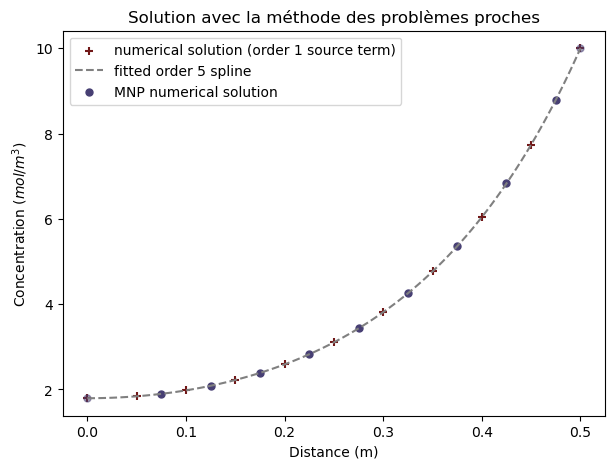

In [289]:
fig, ax = plt.subplots(figsize=(7,5))
plt.scatter(NePro.R_ref[::10], NePro.C_ref[::10], 30, marker='+', color='#711818', label='numerical solution (order 1 source term)')
plt.plot(NePro.R_ref, NePro.spl(NePro.R_ref), linestyle='--', color='0.5', label='fitted order 5 spline')
plt.scatter(NePro.R_ref[15::10], C2[15::10], 25, color='#473F73', label='MNP numerical solution')
plt.scatter(NePro.R_ref[0], C2[0], 25, color='#473F73', alpha=0.5)
plt.scatter(NePro.R_ref[-1], C2[-1], 25, color='#473F73', alpha=0.5)

ax.set_xlabel('Distance (m)')
ax.set_ylabel(r'Concentration $(mol/m^3)$')
ax.set_title('Solution avec la méthode des problèmes proches')
plt.legend()
plt.show()

In [290]:
NL1 = []
NL2 = []
NLi = []
problem_sizes = np.logspace(1, 3, 10)
for n in problem_sizes:
    NePro = NearProblem(int(n))
    Ci, _ = NePro.solve_with_residual(verbose=True, max_solve_time=5.0, step_size=1e8, solve_tol=1e-9)
    NL1.append(nL1(Ci, NePro.C_ref))
    NL2.append(nL2(Ci, NePro.C_ref))
    NLi.append(nLi(Ci, NePro.C_ref))
    


Time step size : 100000000.0 seconds
Concentration at half domain : 3.1075278553636223
Iteration : 10
Relative change : 5.132683612267705e-07


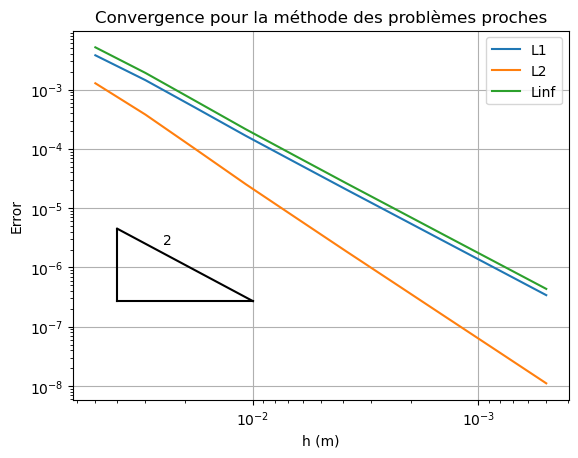

In [291]:
plt.plot(0.5/problem_sizes, NL1, label='L1')
plt.plot(0.5/problem_sizes, NL2, label='L2')
plt.plot(0.5/problem_sizes, NLi, label='Linf')


plt.plot([0.04, 0.01], [4.5e-6, 2.7e-7], color='k')
plt.plot([0.04, 0.04], [4.5e-6, 2.7e-7], color='k')
plt.plot([0.04, 0.01], [2.7e-7, 2.7e-7], color='k')
plt.annotate('2', (0.025, 2.5e-6))

slopes = []
errors = {'L1':NL1, 'L2':NL2, 'Linf':NLi}

ax = plt.gca()
ax.invert_xaxis()
ax.set_xlabel('h (m)')
ax.set_ylabel('Error')
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Convergence pour la méthode des problèmes proches')
ax.grid()

### Ordres de convergence

In [295]:
errors = {'L1   :':NL1, 'L2   :':NL2, 'Linf :':NLi}

for err in errors:
    result = linregress(np.log(0.5/problem_sizes), np.log(errors[err]))
    print(err, result.slope, result.intercept)

L1   : 2.031554196743305 0.525919569122955
L2   : 2.5402806346995095 0.9611016589213612
Linf : 2.0434080577059994 0.846144020634096


# Partie B) : Méthode des solutions manufacturées

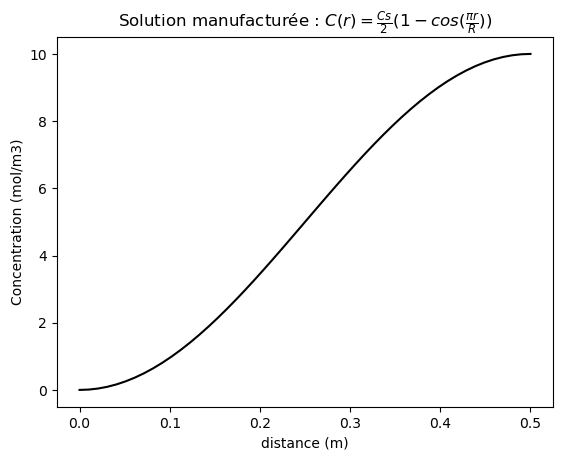

In [298]:
r_vals = np.linspace(0, 0.5)
plt.plot(r_vals, mms_cos(r_vals), color='k')
ax = plt.gca()
ax.set_xlabel('distance (m)')
ax.set_ylabel('Concentration (mol/m3)')
ax.set_title(r'Solution manufacturée : $C(r) = \frac{Cs}{2} (1 - cos(\frac{\pi r}{R}))$')
plt.show()

Time step size : 10.0 seconds
Concentration at half domain : 4.999140170118388
Iteration : 107
Relative change : 1.483702310652178e-11


Text(0, 0.5, 'Concentration (mol/m3)')

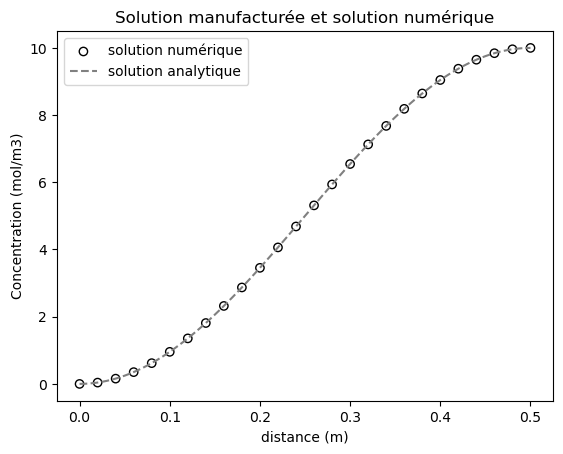

In [299]:
sol = ManufacturedSol(101, mms_source_cos)
Cmn, Rmn = sol.solve_with_residual(verbose=True, max_solve_time=5.0, min_steps=100, step_size=1e8, solve_tol=1e-9, min_time=1)
plt.scatter(Rmn[::4], Cmn[::4], edgecolor='k', facecolors='none', label='solution numérique')
plt.plot(Rmn, mms_cos(Rmn), color='0.5', linestyle="--", label='solution analytique')
plt.title(r"Solution manufacturée et solution numérique")
plt.legend()
plt.gca().set_xlabel('distance (m)')
plt.gca().set_ylabel('Concentration (mol/m3)')

In [301]:
NL1 = []
NL2 = []
NLi = []
problem_sizes = np.logspace(1, 3, 10)

for n in problem_sizes:
    NePro = ManufacturedSol(int(n), mms_source_cos)
    Ci, Ri = NePro.solve_with_residual(verbose=True, max_solve_time=10.0, step_size=1e8, solve_tol=1e-9)
    NL1.append(nL1(Ci, mms_cos(Ri)))
    NL2.append(nL2(Ci, mms_cos(Ri)))
    NLi.append(nLi(Ci, mms_cos(Ri)))
    

Time step size : 100000000.0 seconds
Concentration at half domain : 5.007853231671691
Iteration : 106
Relative change : 8.32373582320957e-07


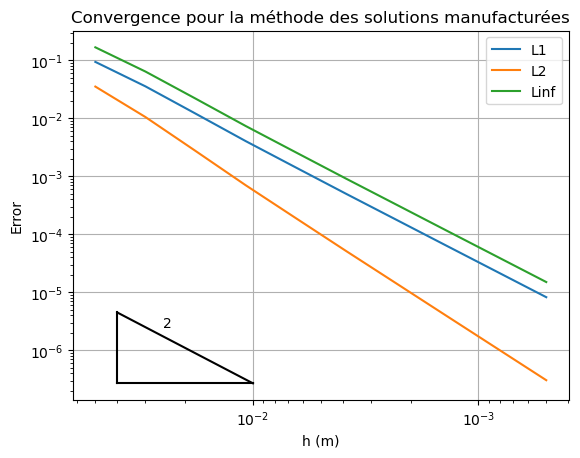

In [303]:
plt.plot(0.5/problem_sizes, NL1, label='L1')
plt.plot(0.5/problem_sizes, NL2, label='L2')
plt.plot(0.5/problem_sizes, NLi, label='Linf')


plt.plot([0.04, 0.01], [4.5e-6, 2.7e-7], color='k')
plt.plot([0.04, 0.04], [4.5e-6, 2.7e-7], color='k')
plt.plot([0.04, 0.01], [2.7e-7, 2.7e-7], color='k')
plt.annotate('2', (0.025, 2.5e-6))

slopes = []
errors = {'L1':NL1, 'L2':NL2, 'Linf':NLi}

ax = plt.gca()
ax.invert_xaxis()
ax.set_xlabel('h (m)')
ax.set_ylabel('Error')
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Convergence pour la méthode des solutions manufacturées')
ax.grid()

In [304]:
errors = {'L1   :':NL1, 'L2   :':NL2, 'Linf :':NLi}

for err in errors:
    result = linregress(np.log(0.5/problem_sizes), np.log(errors[err]))
    print(err, result.slope, result.intercept)

L1   : 2.0370709126906554 3.747219601254729
L2   : 2.542352627034491 4.289429233626938
Linf : 2.0331722867577264 4.3233668286845806
